## **Capstone MDS - ADABoost**

#### **_Integrantes:_**  

1. Evans Díaz   
1. Felipe Ojeda
1. Javier Cofre  
1. Luis Reinoso

In [1]:
# importar librerías
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from matplotlib.ticker import EngFormatter

In [2]:
# función cálculo R2, RMSE y MSE
def R2_RMSE(y_true, y_pred):
  # cálculo de R2 y RMSE
  r2 = r2_score(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  
  return print('R2:',r2), print('RMSE:',rmse), print('MSE:', mse)

## **_1. Lectura (carga) de los Datos_**

In [3]:
# importamos archivo
df = pd.read_csv('../Data/df_final_pay_des.csv')

In [4]:
# miramos el dataframe
df.head()

,crew_E2,crew_E3,crew_E4,day_10,day_11,day_12,day_13,day_14,day_15,day_16,...,CAT 798-AC_des,KOM-CHQ_des,KOM.960E5_des,Kom.930E-4_des,Kom.930E-4SE_des,Kom.930EN_des,Kom.930ER_des,Kom.930ER-MT_des,Kom.980E5_des,Komatsu AHS_des
0,False,False,True,False,False,False,False,False,False,False,...,-0.21334,-0.575556,2.735792,0.191462,0.563663,2.277691,0.101727,-0.035749,-2.98167,-0.101592
1,True,False,False,False,False,False,False,False,False,False,...,-0.21334,-0.575556,2.735792,0.191462,0.607062,2.277691,0.101727,-0.035749,-2.98167,-0.101592
2,False,False,True,False,False,False,False,False,False,False,...,-0.21334,-0.575556,2.735792,0.191462,0.520264,2.277691,0.101727,-0.035749,-2.98167,-0.101592
3,True,False,False,False,False,False,False,False,False,False,...,-0.21334,-0.575556,2.735792,-1.756724,0.607062,2.277691,0.101727,-0.035749,-2.98167,-0.101592
4,False,False,True,False,False,False,False,False,False,False,...,-0.21334,-0.575556,2.735792,0.191462,0.563663,2.277691,0.101727,-0.035749,-2.98167,-0.101592


In [5]:
# información general df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 86 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   crew_E2               1565 non-null   bool   
 1   crew_E3               1565 non-null   bool   
 2   crew_E4               1565 non-null   bool   
 3   day_10                1565 non-null   bool   
 4   day_11                1565 non-null   bool   
 5   day_12                1565 non-null   bool   
 6   day_13                1565 non-null   bool   
 7   day_14                1565 non-null   bool   
 8   day_15                1565 non-null   bool   
 9   day_16                1565 non-null   bool   
 10  day_17                1565 non-null   bool   
 11  day_18                1565 non-null   bool   
 12  day_19                1565 non-null   bool   
 13  day_2                 1565 non-null   bool   
 14  day_20                1565 non-null   bool   
 15  day_21               

## **_2 Preparación del DataFrame_**

In [6]:
# transformamos las variables bool a categorical y le asignamos 0 o 1
for col in df.columns:
  if df[col].dtype == 'bool':
     df[col] = df[col].astype('category').cat.codes
     df[col] = df[col].astype('category') # para que quede como category y no como int8

In [7]:
print('Nombre Columnas: ',df.columns)
print('Cantidad Columnas: ',len(df.columns))

Nombre Columnas:  Index(['crew_E2', 'crew_E3', 'crew_E4', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_2',
       'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26',
       'day_27', 'day_28', 'day_29', 'day_3', 'day_30', 'day_31', 'day_4',
       'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'distance',
       'distance_down', 'distance_down_level', 'distance_up',
       'distance_up_level', 'lift_down', 'lift_down_level', 'lift_up',
       'lift_up_level', 'month_10', 'month_11', 'month_12', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'pay_original', 'shift_B', 'travel_time', 'year_2023',
       'year_2024', 'total_des', 'efectivo_des', 'mantencion_des',
       'mecanica_des', 'electrica_des', 'mant_excl_des', 'mec_excl_des',
       'elec_excl_des', 'som_excl_des', 'demora_des', 'r_prog_des',
       'r_noprg_des', 'waiting_des', 'queued_des', '

In [8]:
# cálculamos la desviaicón estándar y la media de payload
std_y = df['pay_original'].std()
mean_y = df['pay_original'].mean()

print('Desviación Estándar:',std_y)
print('Media:',mean_y)

Desviación Estándar: 19865.315566014815
Media: 142292.45186568802


In [9]:
# estandarizamos las variables numéricas
col_num = df.drop('pay_original', axis=1).select_dtypes(include=['float64','int64']).columns

scaler = StandardScaler()
df[col_num] = scaler.fit_transform(df[col_num])

## **_3 ADABoost_**

In [10]:
# definimos el tamaño del set de test
test_size = 0.10

In [11]:
# separamos los datos en X e y
X = df.drop('pay_original', axis=1)
y = df['pay_original']

# dividimos los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 

In [12]:
# Crear un regresor de árbol de decisión como modelo base, con un solo nodo de decisión (profundidad = 1)
base_estimator = DecisionTreeRegressor(max_depth=1)

In [13]:
# Inicializar el regresor AdaBoost
ada_boost_reg = AdaBoostRegressor(estimator=base_estimator, 
                                  n_estimators=50, 
                                  learning_rate=1.0, 
                                  random_state=42)

In [14]:
# Entrenar el modelo AdaBoost
ada_boost_reg.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1), random_state=42)

In [15]:
# Realizar predicciones en el conjunto de entrenamiento
predictions_train = ada_boost_reg.predict(X_train)

In [16]:
# resultados de R2, RMSE y MSE
R2_RMSE(y_train, predictions_train)

R2: 0.4856790427828058
RMSE: 14285.832748812358
MSE: 204085017.32703963


(None, None, None)

In [17]:
# Realizar predicciones con el modelo entrenado
predictions_test = ada_boost_reg.predict(X_test)

In [18]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_test, predictions_test)

R2: 0.43944439146497294
RMSE: 14409.77919449364
MSE: 207641736.4340618


(None, None, None)

## _4 Optimización del Modelo_ 

### _4.1 Selección de Variables (LassoCV)_

In [19]:
# buscamos alpha optimo con LassoCV
alpha_values = np.linspace(0.01, 300, 30000)

# Crea un objeto LassoCV
lasso_cv = LassoCV(alphas=alpha_values, cv=5)

# Ajusta el modelo a los datos de entrenamiento
lasso_cv.fit(X_train, y_train)

# Valor óptimo de alpha
best_alpha = lasso_cv.alpha_

# Evalúa el modelo en el conjunto de prueba
score = lasso_cv.score(X_test, y_test)

print(f"Mejor valor de alpha: {best_alpha}")
print(f"Puntuación en el conjunto de prueba: {score}")

/home/evansdl/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74817804.3538208, tolerance: 43548029.36598901
  model = cd_fast.enet_coordinate_descent_gram(
/home/evansdl/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116494660.27137756, tolerance: 43548029.36598901
  model = cd_fast.enet_coordinate_descent_gram(
/home/evansdl/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158688826.16763306, tolerance: 43548029.36598901
  model = cd_fast.enet_coordinate_descent_gram(
/home/evansdl/miniconda3/en

Mejor valor de alpha: 155.06
Puntuación en el conjunto de prueba: 0.6243920166797126


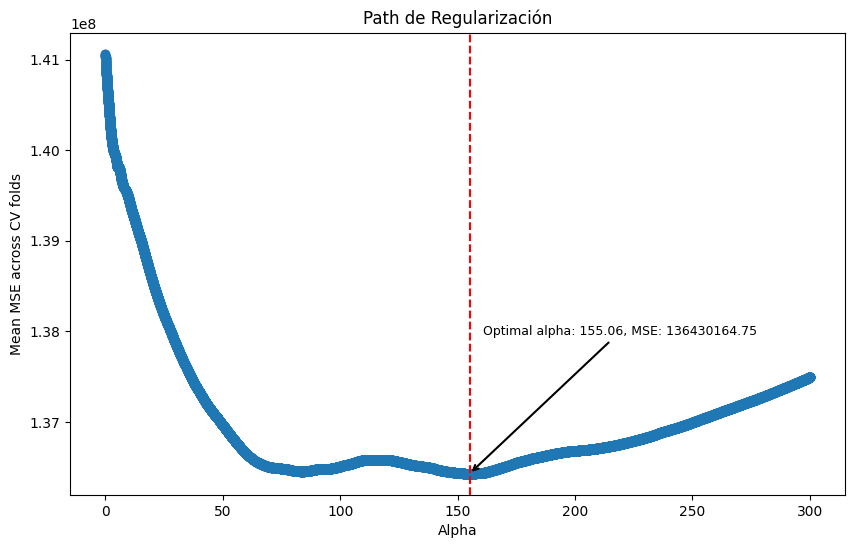

In [20]:
# Graficar MSE vs. Alpha
plt.figure(figsize=(10,6))
plt.plot(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1), '-o')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE across CV folds')
plt.title('Path de Regularización')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--')

# Anotar el valor óptimo de alpha en el gráfico
plt.annotate(f'Optimal alpha: {lasso_cv.alpha_:.2f}, MSE: {np.min(np.mean(lasso_cv.mse_path_, axis=1)):.2f}',
             xy=(lasso_cv.alpha_, np.min(np.mean(lasso_cv.mse_path_, axis=1))),
             xycoords='data', xytext=(10,100), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", lw=1.5),
             fontsize=9)

plt.show()

In [21]:
# Aplicar Lasso para la selección de características
lasso = Lasso(alpha=lasso_cv.alpha_)  
lasso.fit(X_train, y_train)

# Seleccionar las características que tienen coeficientes no nulos
selected_features = X_train.columns[lasso.coef_ != 0]

print("Características seleccionadas:")
print(selected_features)


Características seleccionadas:
Index(['crew_E2', 'crew_E4', 'distance', 'distance_down_level',
       'distance_up_level', 'lift_down', 'month_3', 'month_6', 'shift_B',
       'year_2024', 'electrica_des', 'mant_excl_des', 'mec_excl_des',
       'som_excl_des', 'waiting_des', 'queued_des', 'payload_des',
       'expected_time_des', 'CAT 797-F_des', 'CAT 798-AC_des', 'KOM-CHQ_des',
       'Kom.930E-4_des', 'Kom.930ER_des', 'Komatsu AHS_des'],
      dtype='object')


In [22]:
len(selected_features)

24

> Volvemos ajustar el modelo con las variables seleccionadas

In [23]:
# separamos los datos en train y test
X_lasso= df[selected_features]
y_lasso = df['pay_original']

# dividimos los datos en train y test
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=test_size, random_state=42)

In [24]:
# Inicializar el regresor AdaBoost
ada_boost_reg_lasso = AdaBoostRegressor(estimator=base_estimator, 
                                  n_estimators=50, 
                                  learning_rate=1.0, 
                                  random_state=42)

In [25]:
# Entrenar el modelo AdaBoost
ada_boost_reg_lasso.fit(X_train_lasso, y_train_lasso)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1), random_state=42)

#### 4.1.1 Predicciones en el conjunto de entrenamiento

In [26]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_train = ada_boost_reg_lasso.predict(X_train_lasso)

In [27]:
# Evaluar la precisión del modelo
mse = mean_squared_error(y_train_lasso, predictions_lasso_train)
print(f'Mean Squared Error of AdaBoost Regressor: {mse:.2f}')

Mean Squared Error of AdaBoost Regressor: 203024204.31


In [28]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_train_lasso, predictions_lasso_train)

R2: 0.4883524304309319
RMSE: 14248.65622834734
MSE: 203024204.31362143


(None, None, None)

#### 4.1.2 Predicciones en el conjunto de testeo

In [29]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_test = ada_boost_reg_lasso.predict(X_test_lasso)

In [30]:
# Evaluar la precisión del modelo
mse = mean_squared_error(y_test_lasso, predictions_lasso_test)
print(f'Mean Squared Error of AdaBoost Regressor: {mse:.2f}')

Mean Squared Error of AdaBoost Regressor: 208037964.89


In [31]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_test_lasso, predictions_lasso_test)

R2: 0.43837472172086256
RMSE: 14423.521237538213
MSE: 208037964.88971585


(None, None, None)

### _4.2 Optimización de Hiperparámetros_

In [32]:
# Definir los hiperparámetros para la búsqueda
param_dist_tree = {
    'max_depth': randint(1, 200),
    'min_samples_split': randint(2, 200),
    'min_samples_leaf': randint(1, 200)
}

# Crear la búsqueda de hiperparámetros para DecisionTreeRegressor
random_search_tree = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(),
    param_distributions=param_dist_tree,
    n_iter=100,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Ajustar el modelo
random_search_tree.fit(X_train_lasso, y_train_lasso)

# Mejor combinación de hiperparámetros para el árbol de decisión
best_params_tree = random_search_tree.best_params_
print("Best parameters for DecisionTreeRegressor: ", best_params_tree)


Best parameters for DecisionTreeRegressor:  {'max_depth': 122, 'min_samples_leaf': 75, 'min_samples_split': 89}


In [33]:
# Crear el DecisionTreeRegressor con los mejores parámetros encontrados
best_tree = DecisionTreeRegressor(**best_params_tree)

# Crear el modelo AdaBoost con el mejor DecisionTreeRegressor como base
ada_boost = AdaBoostRegressor(estimator=best_tree)

# Definir los hiperparámetros para la búsqueda de AdaBoost
param_dist_boost = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.001, 2.0),
    'loss': ['linear', 'square', 'exponential']
}

# Crear la búsqueda de hiperparámetros para AdaBoostRegressor
random_search_boost = RandomizedSearchCV(
    estimator=ada_boost,
    param_distributions=param_dist_boost,
    n_iter=100,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Ajustar el modelo
random_search_boost.fit(X_train_lasso, y_train_lasso)

# Mejor combinación de hiperparámetros para AdaBoost
best_params_boost = random_search_boost.best_params_
print("Best parameters for AdaBoostRegressor: ", best_params_boost)

Best parameters for AdaBoostRegressor:  {'learning_rate': 0.2039430857320642, 'loss': 'exponential', 'n_estimators': 202}


In [34]:
# Crear el modelo AdaBoost con los mejores hiperparámetros encontrados
best_boost = AdaBoostRegressor(estimator=best_tree, **best_params_boost)

# Entrenar el modelo AdaBoost con los mejores hiperparámetros
best_boost.fit(X_train_lasso, y_train_lasso)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=122,
                                                  min_samples_leaf=75,
                                                  min_samples_split=89),
                  learning_rate=0.2039430857320642, loss='exponential',
                  n_estimators=202)

In [35]:
# Realizar predicciones en el conjunto de entrenamiento
train_predictions = best_boost.predict(X_train_lasso)

# Realizar predicciones en el conjunto de prueba
test_predictions = best_boost.predict(X_test_lasso)

In [36]:
# Evaluar el modelo en el conjunto de entrenamiento
train_r2 = r2_score(y_train_lasso, train_predictions)
train_mse = mean_squared_error(y_train_lasso, train_predictions)
train_rmse = np.sqrt(train_mse)

print(f"R2 en el conjunto de entrenamiento: {train_r2:.2f}")
print(f"RMSE en el conjunto de entrenamiento: {train_rmse:.2f}")

R2 en el conjunto de entrenamiento: 0.72
RMSE en el conjunto de entrenamiento: 10500.90


In [37]:
# Evaluar el modelo en el conjunto de prueba
test_r2 = r2_score(y_test_lasso, test_predictions)
test_mse = mean_squared_error(y_test_lasso, test_predictions)
test_rmse = np.sqrt(test_mse)

print(f"R2 en el conjunto de prueba: {test_r2:.2f}")
print(f"RMSE en el conjunto de prueba: {test_rmse:.2f}")

R2 en el conjunto de prueba: 0.61
RMSE en el conjunto de prueba: 12058.93
